In [2]:
import pandas as pd

In [3]:
train_df = pd.read_csv("data/covidx-cxr2/train.txt", sep=" ", names=["study_id", "img_path", "label", "source"])
test_df = pd.read_csv("data/covidx-cxr2/test.txt", sep=" ", names=["study_id", "img_path", "label", "source"])
label_names = ["covid"]

In [3]:
train_df["label"].value_counts()

positive    16490
negative    13992
Name: label, dtype: int64

In [4]:
train_df.groupby("label")["source"].value_counts()

label     source    
negative  rsna          13389
          cohen           297
          rnsa            199
          actmed          107
positive  stonybrook    14132
          sirm            943
          ricord          896
          cohen           270
          bimcv           200
          actmed           25
          fig1             24
Name: source, dtype: int64

In [5]:
test_df.groupby("label")["source"].value_counts()

label     source
negative  rsna      200
positive  ricord    200
Name: source, dtype: int64

In [6]:
test_df["source"].value_counts()

ricord    200
rsna      200
Name: source, dtype: int64

In [7]:
train_df.columns

Index(['study_id', 'img_path', 'label', 'source'], dtype='object')

In [8]:
train_df.rename({})

,study_id,img_path,label,source
0,5,ARDSSevere.png,negative,cohen
1,25,acute-respiratory-distress-syndrome-ards-1.jpg,negative,cohen
2,26,acute-respiratory-distress-syndrome-ards.jpg,negative,cohen
3,27,ards-secondary-to-tiger-snake-bite.png,negative,cohen
4,28,pneumocystis-pneumonia-2-PA.png,negative,cohen
...,...,...,...,...
30477,55204bb8-89fc-449d-8563-e91654abea9d,55204bb8-89fc-449d-8563-e91654abea9d.png,negative,rnsa
30478,0f4b80b6-fd39-451f-aebf-7cdb1b655c0b,0f4b80b6-fd39-451f-aebf-7cdb1b655c0b.png,negative,rnsa
30479,5fb64e85-62ef-4852-8ad1-f799015c8cc3,5fb64e85-62ef-4852-8ad1-f799015c8cc3.png,negative,rnsa
30480,c57ad4fd-3aa8-4ae8-a262-7336360d8265,c57ad4fd-3aa8-4ae8-a262-7336360d8265.png,negative,rnsa


In [9]:
# binarize labels
train_df["label"] = train_df["label"].apply(lambda x: 1 if x == "positive" else 0)
test_df["label"] = test_df["label"].apply(lambda x: 1 if x == "positive" else 0)

# add train and test folder to img path 
train_df["img_path"] = "train/" + train_df["img_path"]
test_df["img_path"] = "test/" + test_df["img_path"]

In [10]:
# define splits
from sklearn.model_selection import train_test_split
real_train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)
real_train_df["split"] = "train"
val_df["split"] = "val"
test_df["split"] = "test"

# merge splits
total_df = pd.concat([real_train_df, val_df, test_df])

# convert label int column to numpy arrays
import numpy as np
total_df["labels"] = total_df["label"].apply(lambda x: np.array([x]))
total_df = total_df.drop(columns=["label"])

# add absolute total path to img_path
import os
total_df["img_path"] = total_df["img_path"].apply(lambda x: os.path.join("/srv/home/8wiehe/master_thesis/data/covidx-cxr2/", x))

new_root_path = "/srv/home/8wiehe/master_thesis/data/covidx-cxr2/small_all/"
os.makedirs(new_root_path, exist_ok=True)
from mimic_preprocessing import resize_img
from PIL import Image

# resize images and adjust img_path to new path
def resize_and_save(img_path, new_root_path):
    img = Image.open(img_path).convert("RGB")
    img = resize_img(img, 256)
    img.save(os.path.join(new_root_path, img_path.split("/")[-1]), quality=95, subsampling=0)
# resize
# init tqdm  progress apply
from tqdm import tqdm
tqdm.pandas()
total_df["img_path"].progress_apply(lambda x: resize_and_save(x, new_root_path))
# change paths
total_df["img_path"] = total_df["img_path"].apply(lambda path: os.path.join(new_root_path, path.split("/")[-1]))


100%|██████████| 30882/30882 [20:44<00:00, 24.82it/s]


/srv/home/8wiehe/master_thesis/data/covidx-cxr2/small_all/MIDRC-RICORD-1C-SITE2-000106-15732-0.png
[1]
(256, 210)


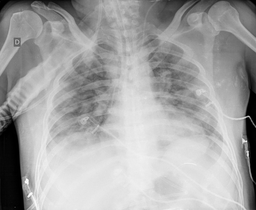

In [11]:
# test image loading
from PIL import Image

idx = -300

path = total_df.iloc[idx]["img_path"]
print(path)
# print label
print(total_df.iloc[idx]["labels"])
pil_img = Image.open(path)
print(pil_img.size)
pil_img

In [13]:
# save df
os.makedirs("covidx", exist_ok=True)
total_df.to_pickle("covidx/final_df.pkl")
import numpy as np
np.save("covidx/label_names.npy", label_names)

In [ ]:
df

In [ ]:
label_names